In [3]:
import os
import sys
sys.path.append('../')

from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image
from tqdm import tqdm
import numpy as np
from openai import OpenAI
import torch

from PIL import Image
import os

from dataset import PetsDataset

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [5]:
os.environ["OPENAI_API_KEY"] = ""
assert "YOUR_API_KEY" != os.environ["OPENAI_API_KEY"], "Please set your OpenAI API key in the environment variable"

In [6]:
# Load model
model_name = "stabilityai/stable-diffusion-2-1-unclip"
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    model_name, torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

image_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

(…)_noising_scheduler/scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

image_normalizer/config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.48G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

/home/haselab/miniconda3/envs/apap/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def calculate_image_embeds(pipe: StableUnCLIPImg2ImgPipeline, input_image: Image.Image) -> torch.Tensor:
    """Calculate image embeddings using the image encoder of the pipeline.
    Args:
        pipe: The pipeline object.
        input_image: The input image.
    Returns:
        torch.Tensor: The image embeddings. shape of (1, 1024).
    """
    # Preprocess image
    image = pipe.feature_extractor(images=input_image, return_tensors="pt").pixel_values
    image = image.to(device)

    image_embeds = pipe.image_encoder(image).image_embeds
    return image_embeds

In [9]:
dataset = PetsDataset(
    "../data",
    transform=None,
)
pets_cls_dict = {}

prev_key = None
for i, item in tqdm(enumerate(dataset), total=len(dataset)):
    key = item["path"].split("/")[-1].split("_")[0]
    if prev_key is None:
        prev_key = key
        pets_cls_dict[key] = []
    
    if prev_key != key:
        prev_key = key
        pets_cls_dict[key] = []
        
    pets_cls_dict[prev_key].append(i)

  0%|          | 0/3680 [00:00<?, ?it/s]

100%|██████████| 3680/3680 [00:06<00:00, 584.50it/s]


In [10]:
pets_cls_dict.keys()

dict_keys(['Abyssinian', 'american', 'basset', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British', 'chihuahua', 'Egyptian', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'Maine', 'miniature', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian', 'saint', 'samoyed', 'scottish', 'shiba', 'Siamese', 'Sphynx', 'staffordshire', 'wheaten', 'yorkshire'])

In [11]:
def apply_tsne(embeds: torch.Tensor, n_components: int = 2) -> np.ndarray:
    """Apply t-SNE to the embeddings.
    Args:
        embeds: The embeddings. shape of (num_samples, embed_dim).
        n_components: The number of components.
    Returns:
        np.ndarray: The 2D embeddings.
    """
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=n_components, random_state=0)
    embeds_2d = tsne.fit_transform(embeds)
    return embeds_2d

def apply_pca(embeds: torch.Tensor, n_components: int = 2) -> np.ndarray:
    """Apply PCA to the embeddings.
    Args:
        embeds: The embeddings. shape of (num_samples, embed_dim).
        n_components: The number of components.
    Returns:
        np.ndarray: The 2D embeddings.
    """
    from sklearn.decomposition import PCA

    pca = PCA(n_components=n_components)
    embeds_2d = pca.fit_transform(embeds)
    return embeds_2d

def apply_umap(embeds: torch.Tensor, n_components: int = 2) -> np.ndarray:
    """Apply UMAP to the embeddings.
    Args:
        embeds: The embeddings. shape of (num_samples, embed_dim).
        n_components: The number of components.
    Returns:
        np.ndarray: The 2D embeddings.
    """
    import umap

    reducer = umap.UMAP(n_components=n_components)
    embeds_2d = reducer.fit_transform(embeds)
    return embeds_2d

In [12]:
# generate text embeddings
def calculate_text_embeds(pipe: StableUnCLIPImg2ImgPipeline, text: str) -> torch.Tensor:
    """Calculate text embeddings using the text encoder of the pipeline.
    Args:
        pipe: The pipeline object.
        text: The input text.
    Returns:
        torch.Tensor: The text embeddings. shape of (1, 1024).
    """
    text_inputs = pipe.tokenizer(
        text,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    text_embeds = pipe.text_encoder(text_input_ids).pooler_output
    text_embeds = pipe.text_encoder.text_model.final_layer_norm(text_embeds)
    
    return text_embeds

In [13]:
import base64
import requests
from json import JSONDecodeError
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def generate_captions(
    llm: str,
    clsname: str,
    num_real_samples: int,
    is_visual: bool = True,
    image_paths: list = None,
):
    client = OpenAI()
    if not is_visual:
        while True:
            response = client.chat.completions.create(
                model=llm,
                messages=[
                    {"role": "system", "content": f"Generate captions for {clsname} images. Specify detail visual attributes. You have to generate {num_real_samples} captions seperated by '|'. For example, 'A cat with blue eyes and white fur.'"},
                ]
            )
            output = response.choices[0].message.content
            gen_captions = output.split("|")
            if len(gen_captions) == num_real_samples:
                break
            else:
                print("Re-try generating captions.")
    else:
        assert image_paths is not None, "Please provide image paths."
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
        }
        gen_captions = []
        for path in tqdm(image_paths):
            while True:
                base64_image = encode_image(path)
                payload = {
                    "model": f"{llm}",
                    "messages": [
                        {
                        "role": "user",
                        "content": [
                            {
                            "type": "text",
                            "text": "Please generate a caption for this image. Specify detail visual attributes. Describe the image in detail."
                            },
                            {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                            }
                        ]
                        }
                    ],
                    "max_tokens": 300
                }
                response = requests.post(
                    "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
                )
                try:
                    output = response.json()["choices"][0]["message"]["content"]
                    break
                except JSONDecodeError:
                    print(response.json())
                    print("Re-try generating captions.")
                    continue
            output = response.json()["choices"][0]["message"]["content"]
            gen_captions.append(output)
    return gen_captions

In [14]:
def calculate_embeds(
    pets_cls_dict: dict,
    clsname: str, 
    pipe: StableUnCLIPImg2ImgPipeline,
    dataset: PetsDataset,
    llm: str = "gpt-4o-mini",
    is_visual: bool = False,
):
    picked_cls_idx = pets_cls_dict[clsname]
    image_paths = [dataset[idx]["path"] for idx in picked_cls_idx]
    num_real_samples = len(picked_cls_idx)
    
    # Calculate image embeddings
    print("Calculating image embeddings...")
    image_embeds = []
    for i in tqdm(range(num_real_samples)):
        idx = picked_cls_idx[i]
        item = dataset[idx]

        image = item["image"]
        image_embeds.append(calculate_image_embeds(pipe, image))
    image_embeds = torch.cat(image_embeds, dim=0).cpu().detach()  # (num_real_samples, 1024)
    
    # Generate captions by asking LLM
    print(f"Generating {len(picked_cls_idx)} captions...")
    gen_captions = generate_captions(llm, clsname, num_real_samples, is_visual, image_paths)
    
    # Calculate text embeddings
    print("Calculating text embeddings...")
    text_embeds = []
    for i in tqdm(range(num_real_samples)):
        text = gen_captions[i]
        text_embeds.append(calculate_text_embeds(pipe, text))
    text_embeds = torch.cat(text_embeds, dim=0).cpu().detach()  # (num_real_samples, 1024)
      
    return {
        "img_embeds": image_embeds, 
        "text_embeds": text_embeds,
        "gen_captions": gen_captions
    }
    
def apply_reduction(embeds: torch.Tensor, reduction_algo: str = "tsne") -> np.ndarray:
    if reduction_algo == "tsne":
        embeds_2d = apply_tsne(embeds)
    elif reduction_algo == "pca":
        embeds_2d = apply_pca(embeds)
    elif reduction_algo == "umap":
        embeds_2d = apply_umap(embeds)
    else:
        raise ValueError(f"Invalid reduction algorithm: {reduction_algo}")
    return embeds_2d

In [16]:
clslist = ["yorkshire", "staffordshire", "pomeranian", "Persian"]
embeds_dict = {}
captoins_dict = {}

for clsname in clslist:
    embeds = calculate_embeds(pets_cls_dict, clsname, pipe, dataset, llm="gpt-4o-mini",  is_visual=False)
    print(f"Class: {clsname}")
    img_embeds, text_embeds = embeds["img_embeds"], embeds["text_embeds"]
    embeds_dict[clsname] = {
        "image_embeds": img_embeds,
        "text_embeds": text_embeds,
    }

Calculating image embeddings...


100%|██████████| 50/50 [00:01<00:00, 43.58it/s]


Generating 50 captions...
Calculating text embeddings...


100%|██████████| 50/50 [00:00<00:00, 79.58it/s]


Class: yorkshire
Calculating image embeddings...


100%|██████████| 50/50 [00:01<00:00, 40.86it/s]


Generating 50 captions...
Calculating text embeddings...


100%|██████████| 50/50 [00:00<00:00, 80.73it/s]


Class: staffordshire
Calculating image embeddings...


100%|██████████| 50/50 [00:01<00:00, 39.92it/s]


Generating 50 captions...
Calculating text embeddings...


100%|██████████| 50/50 [00:00<00:00, 82.79it/s]


Class: pomeranian
Calculating image embeddings...


100%|██████████| 50/50 [00:01<00:00, 44.03it/s]


Generating 50 captions...
Calculating text embeddings...


100%|██████████| 50/50 [00:00<00:00, 82.11it/s]


Class: Persian


In [18]:
reduction_algo = "tsne"
reduction_embeds_dict = {}
for clsname, embeds in embeds_dict.items():
    img_embeds = embeds["image_embeds"]
    text_embeds = embeds["text_embeds"]
    img_embeds_2d = apply_reduction(img_embeds, reduction_algo=reduction_algo)
    text_embeds_2d = apply_reduction(text_embeds, reduction_algo=reduction_algo)
    
    reduction_embeds_dict[clsname] = {
        "image_embeds_2d": img_embeds_2d,
        "text_embeds_2d": text_embeds_2d,
    }

/tmp/ipykernel_1879655/2060227516.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cls = plt.cm.get_cmap("tab10", len(clslist))


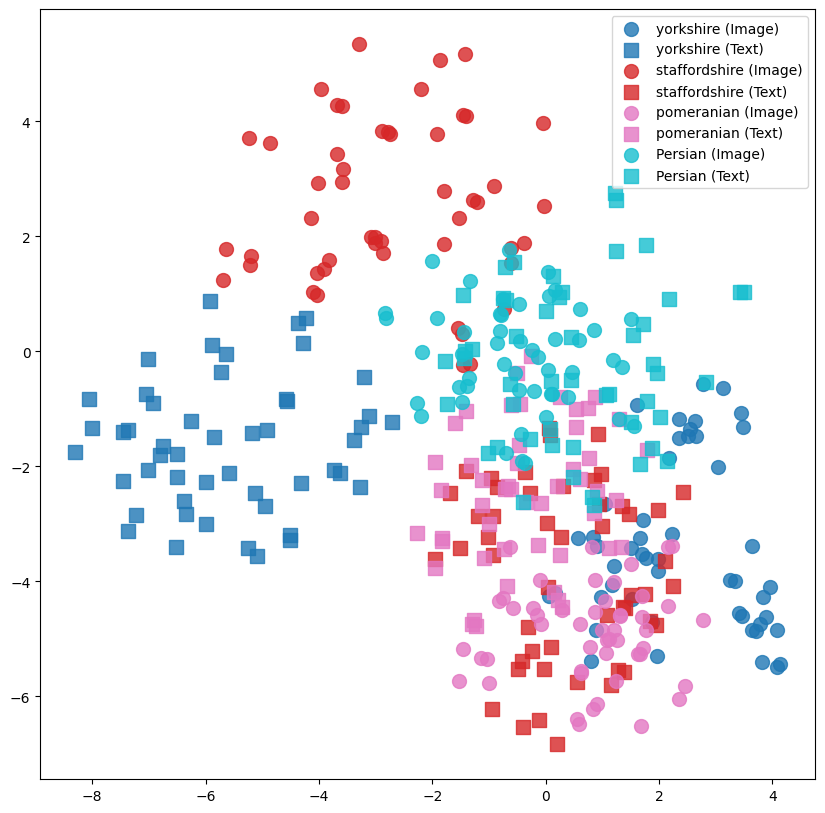

In [19]:
# Plot the embeddings 
# Image embeddings => circle markers
# Text embeddings => square markers
# Different colors for different classes

import matplotlib.pyplot as plt

def plot_embeddings(embeds_dict: dict, clslist: list):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    cmap_cls = plt.cm.get_cmap("tab10", len(clslist))
    for i, clsname in enumerate(clslist):
        color = cmap_cls(i)
        img_embeds = reduction_embeds_dict[clsname]["image_embeds_2d"]
        text_embeds = reduction_embeds_dict[clsname]["text_embeds_2d"]
        
        ax.scatter(img_embeds[:, 0], img_embeds[:, 1], label=f"{clsname} (Image)", marker="o", s=100, alpha=0.8, c=[color])
        ax.scatter(text_embeds[:, 0], text_embeds[:, 1], label=f"{clsname} (Text)", marker="s", s=100, alpha=0.8, c=[color])
    ax.legend()
    plt.show()

plot_embeddings(embeds_dict, clslist)

In [20]:
# Generate images from text embeddings
from sampling_functions import encode, sample, invert, \
    encode_image, encode_prompt, prepare_latents
from torch import Tensor

@torch.no_grad()
def unclip_sampling(
    pipe, 
    prompt: str,
    num_inference_steps: int,
    batch_size: int,
    device: str,
    num_samples: int=1,
    guidance_scale: float=3.5,
    noise_level: int = 0,
    output_type: str="image",
    prefix="",
    height: int=None,
    width: int=None,
) -> np.ndarray:
    do_classifier_free_guidance = guidance_scale > 0.0
    # Get Height and Width
    height = height or pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = width or pipe.unet.config.sample_size * pipe.vae_scale_factor

    # Encode prompt
    prompt_embeds, uncond_prompt_embeds = encode_prompt(pipe, prompt, batch_size, device, num_samples, do_classifier_free_guidance)
    if do_classifier_free_guidance:
        prompt_embeds = torch.cat([prompt_embeds, uncond_prompt_embeds])
    
    # Encode image
    image_embeds = encode_image(pipe, images, device, batch_size, num_samples, do_classifier_free_guidance, noise_level, None)
    image_embeds = image_embeds.to(device, dtype=prompt_embeds.dtype)
    
    # scheduler
    pipe.scheduler.set_timesteps(num_inference_steps=num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps
    
    num_channels_latents = pipe.unet.config.in_channels
    # Prepare latents
    latents = prepare_latents(
        pipe,
        batch_size*num_samples, 
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        latents=None,
    )
    
    print(f"{prefix}: Sampling Images for {num_inference_steps} steps...")
    for i, t in enumerate(pipe.progress_bar(timesteps)):
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                class_labels=image_embeds,
                return_dict=False
            )[0]
        
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    if not output_type == "latent":
        images = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
    else:
        images = latents

    images = images.cpu().detach()
    images = pipe.image_processor.postprocess(images, output_type=output_type)
    return images  # (B, C, H, W)

AttributeError: 'StableUnCLIPImg2ImgPipeline' object has no attribute 'generate_images_from_text'